<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')
df=pd.DataFrame(house)

In [3]:
# Load and review the data description.
f = open("data_description.txt")
print(f.read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

In [4]:
# Check the shape of the DF:
df.shape

(1460, 81)

In [5]:
#Remove four columns with less than 300 values. 
df = df.drop(['Alley','PoolQC','Fence','MiscFeature'], axis=1)

In [6]:
#Remove rows not labeled "residential".
to_drop = ['A', 'C', 'I', 'C (all)']
df = df[~df['MSZoning'].isin(to_drop)]

In [7]:
#Determined that all data with Fireplace Quality listed as 'Nan" also had zero fireplaces
df.FireplaceQu[df.Fireplaces==0].value_counts()

Series([], Name: FireplaceQu, dtype: int64)

In [8]:
#Replaced Nan values in Fireplace Quality with 'NA'
df.loc[df.FireplaceQu.isnull(), 'FireplaceQu'] = 'NA'

In [9]:
#Determined that all data with Garage Type listed as 'Nan" also had no garage
df.GarageType[df.GarageCars==0].value_counts()

Series([], Name: GarageType, dtype: int64)

In [10]:
#Verified that the other 5 Garage related columns also only contained Nan in data listed with no garage. 
#Replaced Nan values in Garage Type and GarageFinish, GarageQual, GarageCond with 'NA'
for i in ['GarageType','GarageFinish','GarageQual','GarageCond']:
    df.loc[df[i].isnull(),i]='NA'

In [11]:
#Determined that all data with Garage Type listed as 'Nan" also had no garage
df.BsmtFinSF1[df.BsmtExposure.isnull()].value_counts()

0    38
Name: BsmtFinSF1, dtype: int64

In [12]:
#Replaced NA values in GarageYrBlt with 0
df.loc[df.GarageYrBlt.isnull(), 'GarageYrBlt'] = 0

In [13]:
#Replaced Nan values in LotFrontage with 0
df.loc[df.LotFrontage.isnull(), 'LotFrontage'] = 0

In [14]:
#Removed any more rows with null values
df.dropna(axis=0, how='any', inplace=True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1402 entries, 0 to 1459
Data columns (total 77 columns):
Id               1402 non-null int64
MSSubClass       1402 non-null int64
MSZoning         1402 non-null object
LotFrontage      1402 non-null float64
LotArea          1402 non-null int64
Street           1402 non-null object
LotShape         1402 non-null object
LandContour      1402 non-null object
Utilities        1402 non-null object
LotConfig        1402 non-null object
LandSlope        1402 non-null object
Neighborhood     1402 non-null object
Condition1       1402 non-null object
Condition2       1402 non-null object
BldgType         1402 non-null object
HouseStyle       1402 non-null object
OverallQual      1402 non-null int64
OverallCond      1402 non-null int64
YearBuilt        1402 non-null int64
YearRemodAdd     1402 non-null int64
RoofStyle        1402 non-null object
RoofMatl         1402 non-null object
Exterior1st      1402 non-null object
Exterior2nd      1402 non

In [16]:
#Grouped variables as either fixed, changeable, or salesdata.
fixed=['MSSubClass','MSZoning','LotFrontage','LotArea','Street','LotShape','LandContour','Utilities','LotConfig',
       'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','YearBuilt','Foundation',
       'TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
       'BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageType','GarageYrBlt','GarageCars','GarageArea']
changeable=['OverallQual','OverallCond','YearRemodAdd','RoofStyle','RoofMatl','Exterior1st','Exterior2nd',
            'MasVnrType','MasVnrArea','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
            'BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','Heating','HeatingQC','CentralAir','Electrical',
            'LowQualFinSF','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond',
            'PavedDrive','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']
salesdata=['MoSold','YrSold','SaleType','SaleCondition','SalePrice']

In [17]:
#Split data into training and testing subgroups
df_train = df[(df['YrSold'] < 2010)]

In [18]:
df_train.shape

(1236, 77)

In [19]:
#Split data into training and testing subgroups
df_test = df[(df['YrSold'] == 2010)]

In [20]:
df_test.shape

(166, 77)

In [21]:
#Creating database of all fixed variables only
df_fixed_train = df_train[['MSSubClass','MSZoning','LotFrontage','LotArea','Street','LotShape','LandContour',
       'Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
       'YearBuilt','Foundation','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
       'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageType','GarageYrBlt',
       'GarageCars','GarageArea']].copy()

In [22]:
#And creating the test database for those same fixed variables
df_fixed_test = df_test[['MSSubClass','MSZoning','LotFrontage','LotArea','Street','LotShape','LandContour',
        'Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
        'YearBuilt','Foundation','TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
        'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageType','GarageYrBlt',
        'GarageCars','GarageArea']].copy()

In [23]:
#Creating database of all changeable variables only
df_change_train = df_train[['OverallQual','OverallCond','YearRemodAdd','RoofStyle','RoofMatl','Exterior1st',
            'Exterior2nd','MasVnrType','MasVnrArea','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',
            'BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','Heating','HeatingQC','CentralAir',
            'Electrical','LowQualFinSF','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
            'GarageCond','PavedDrive','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
            'PoolArea','MiscVal']].copy()

In [24]:
#And creating the test database for those same changeable variables
df_change_test = df_test[['OverallQual','OverallCond','YearRemodAdd','RoofStyle','RoofMatl','Exterior1st',
            'Exterior2nd','MasVnrType','MasVnrArea','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',
            'BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','Heating','HeatingQC','CentralAir',
            'Electrical','LowQualFinSF','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual',
            'GarageCond','PavedDrive','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch',
            'PoolArea','MiscVal']].copy()

In [25]:
#Load the modules needed for a multiple linear regression model
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm 
%matplotlib inline

In [26]:
#Load sales price as the target for our model
target = df_train['SalePrice']

In [27]:
df_fixed_train.describe()

,MSSubClass,LotFrontage,LotArea,YearBuilt,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea
count,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000
mean,56.905340,57.459547,10574.457929,1971.715210,1084.080906,1163.915858,356.503236,1526.549353,0.424757,0.064725,1.567961,0.394013,2.870550,1.034790,6.528317,0.629450,1877.834142,1.784790,477.824434
std,41.968158,34.935742,10541.154075,30.450248,408.693590,386.215833,439.154747,529.625921,0.520045,0.252633,0.549782,0.506729,0.809502,0.196124,1.612203,0.640273,436.042323,0.748956,215.654971
min,20.000000,0.000000,1300.000000,1872.000000,105.000000,438.000000,0.000000,438.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,41.000000,7538.750000,1954.000000,812.500000,882.000000,0.000000,1144.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1958.000000,1.000000,336.000000
50%,50.000000,63.000000,9511.500000,1974.000000,1000.000000,1092.000000,0.000000,1471.500000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1978.000000,2.000000,480.000000
75%,70.000000,79.000000,11695.500000,2001.000000,1311.750000,1392.000000,739.000000,1786.250000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.250000,2.000000,576.000000
max,190.000000,313.000000,215245.000000,2009.000000,6110.000000,4692.000000,2065.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2009.000000,4.000000,1418.000000


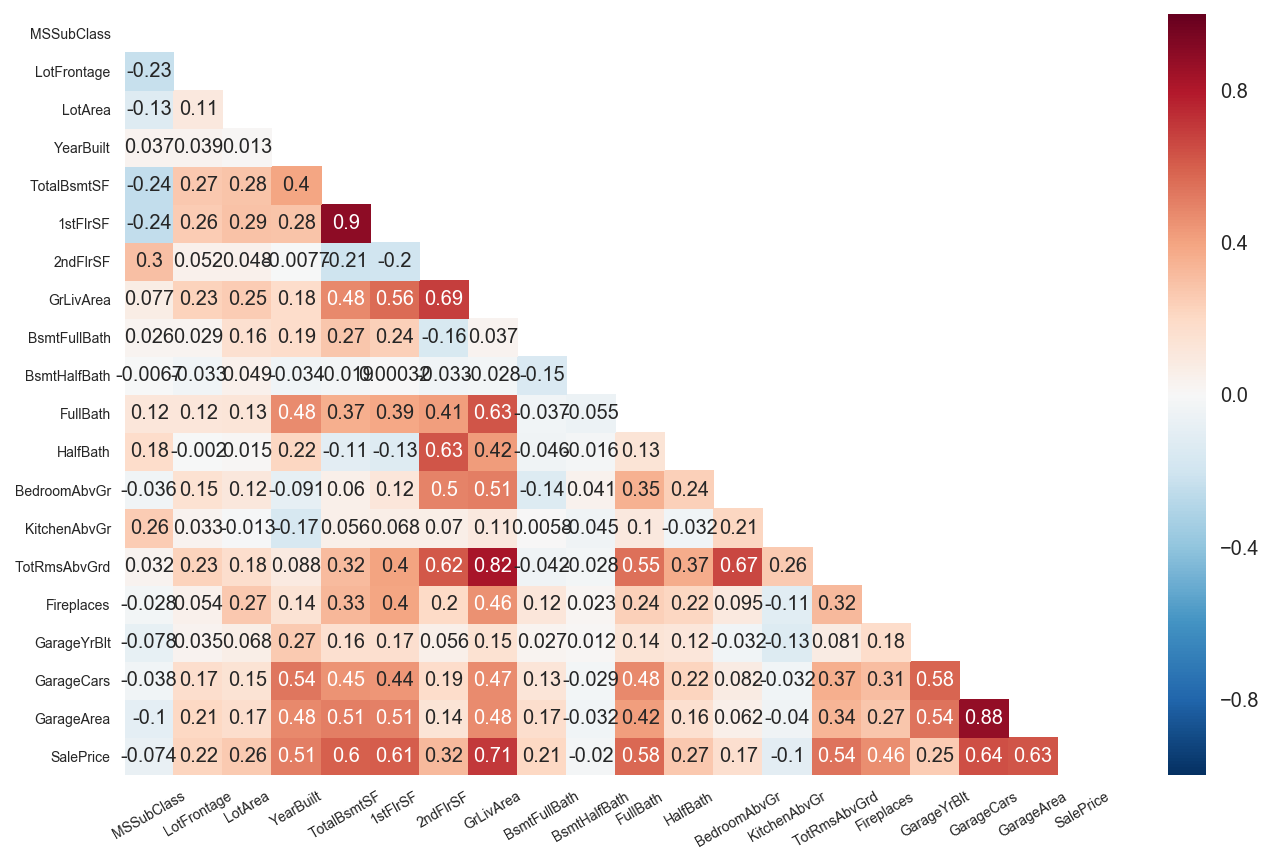

In [28]:
#Running heat map on fixed numerical values
def correlation_heat_map(df):
    corrs = df.corr()
    fig, ax = plt.subplots(figsize=(11,7))
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(corrs, mask=mask, annot=True)
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=7, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=7, rotation=0)
    plt.show()

df_with_target = df_fixed_train.copy()
df_with_target['SalePrice'] = target
correlation_heat_map(df_with_target)

In [29]:
# Initially trying Linear Regression with Statsmodels OLS 
X1 = df_fixed_train[["YearBuilt","TotalBsmtSF","GrLivArea","Fireplaces","GarageCars"]].values
X1 = np.concatenate([X1, np.ones((X1.shape[0], 1))], axis=1)
y1 = df_train["SalePrice"]
model = sm.OLS(y1, X1)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     621.6
Date:                Fri, 02 Jun 2017   Prob (F-statistic):               0.00
Time:                        08:41:31   Log-Likelihood:                -14911.
No. Observations:                1236   AIC:                         2.983e+04
Df Residuals:                    1230   BIC:                         2.987e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1           615.4520     48.471     12.697      0.000       520.357   710.547
x2            32.5126      3.627      8.963      0.000        25.396    39.629
x3            65.7787      2.913     22.579      0.000        60.063    71.494
x4          1.382e+04   2132.441      6.481      0.000      9637.729   1.8e+04
x5          2.107e+04   2148.232      9.807      0.000      1.69e+04  2.53e+04
const      -1.212e+06   9.36e+04    -12.944      0.000      -1.4e+06 -1.03e+06
==============================================================================
Omnibus:                      426.335   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36605.612
Skew:                          -0.634   Prob(JB):                         0.00
Kurtosis:                      29.630   Cond. No.                     2.15e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
# Results: R^2 for the test was .716 on training data, not bad. P-values for all 5 variables were below 0.001, so 
# results seem reasonable. Will now try with test data.

In [31]:
# Now running with test data: 
X2 = df_fixed_test[["YearBuilt","TotalBsmtSF","GrLivArea","Fireplaces","GarageCars"]].values
X2 = np.concatenate([X2, np.ones((X2.shape[0], 1))], axis=1)
y2 = df_test["SalePrice"]
model = sm.OLS(y2, X2)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     116.6
Date:                Fri, 02 Jun 2017   Prob (F-statistic):           1.75e-51
Time:                        08:41:31   Log-Likelihood:                -1981.3
No. Observations:                 166   AIC:                             3975.
Df Residuals:                     160   BIC:                             3993.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1           611.7913    126.790      4.825      0.000       361.393   862.190
x2            68.1238      9.425      7.228      0.000        49.511    86.737
x3            67.6587      7.159      9.451      0.000        53.520    81.797
x4          6763.9753   4919.225      1.375      0.171     -2951.010  1.65e+04
x5          2.063e+04   5450.912      3.786      0.000      9869.597  3.14e+04
const      -1.239e+06   2.44e+05     -5.077      0.000     -1.72e+06 -7.57e+05
==============================================================================
Omnibus:                       79.906   Durbin-Watson:                   2.248
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              656.870
Skew:                           1.532   Prob(JB):                    2.30e-143
Kurtosis:                      12.251   Cond. No.                     2.28e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.28e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
predictions  =  model.predict()

In [33]:
# TEST on first model: R^2 increased to .785. Only one variable, "Fireplaces" showed a positive P-value. 

In [34]:
df_train.shape

(1236, 77)

In [35]:
df_test.shape

(166, 77)

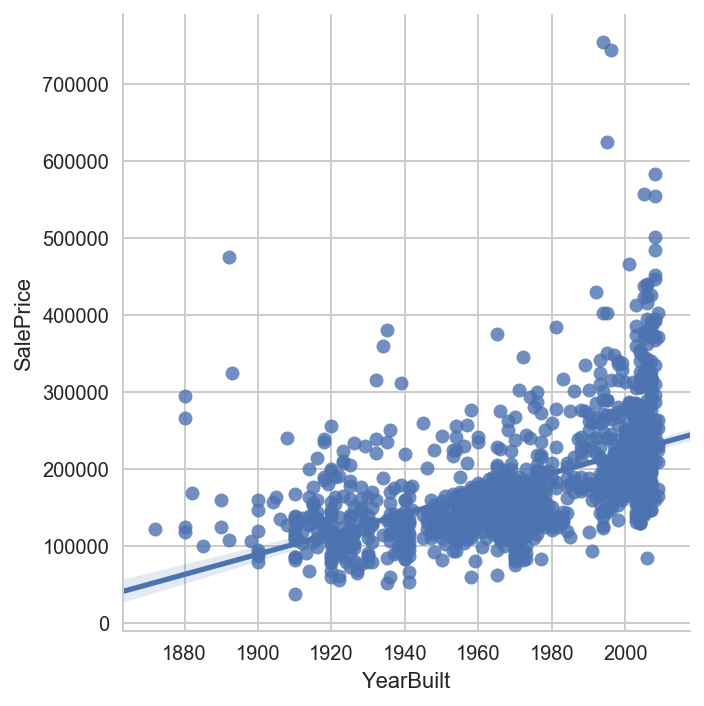

In [36]:
import seaborn as sns

sns.lmplot(x ='YearBuilt',y ='SalePrice', data = df_train)

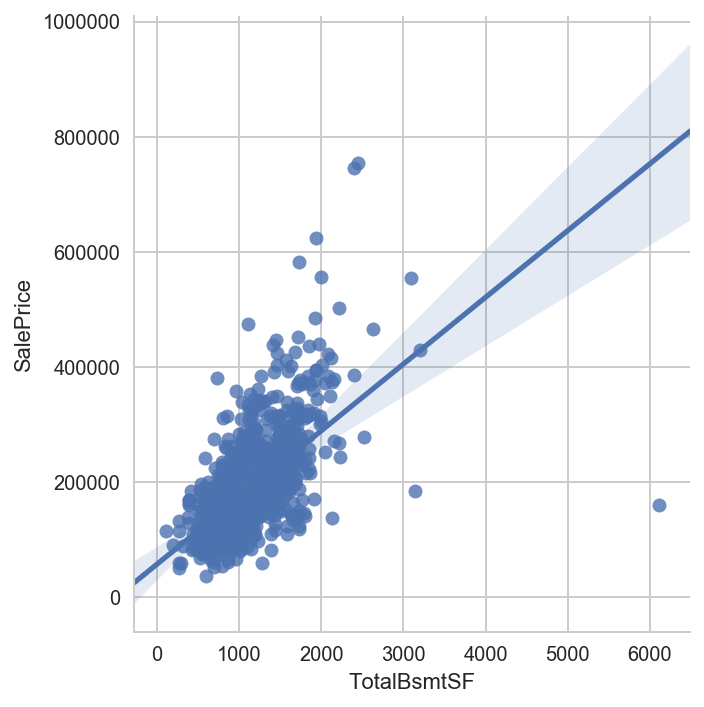

In [37]:
sns.lmplot(x ='TotalBsmtSF',y ='SalePrice', data = df_train)

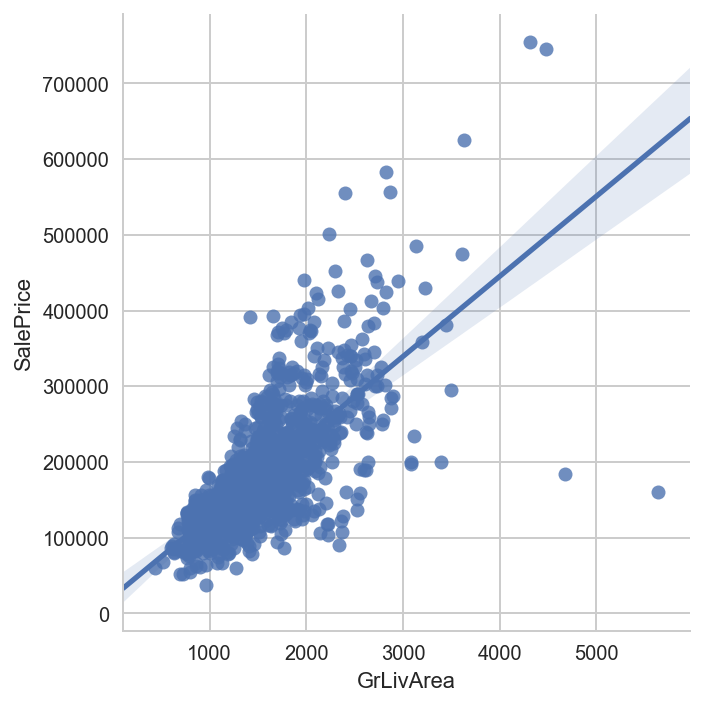

In [38]:
sns.lmplot(x ='GrLivArea',y ='SalePrice', data = df_train)

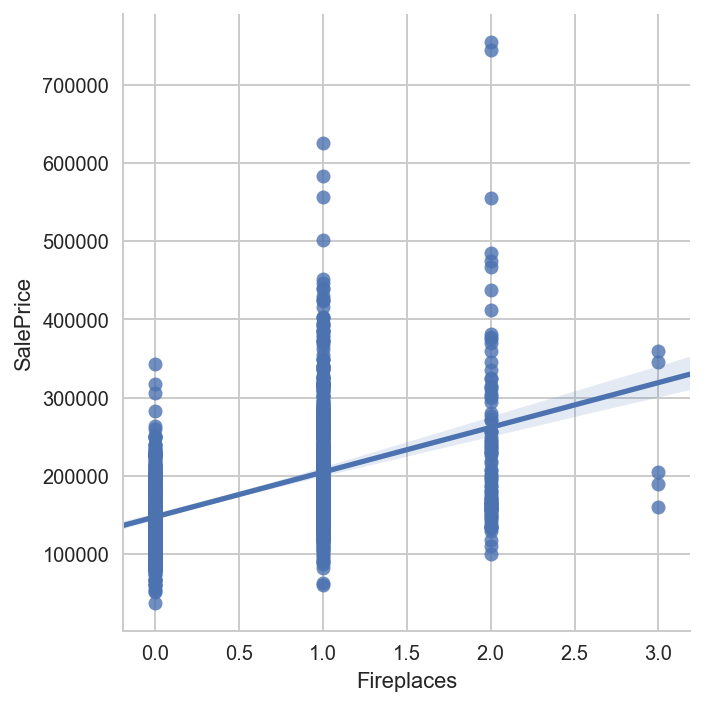

In [39]:
sns.lmplot(x ='Fireplaces',y ='SalePrice', data = df_train)

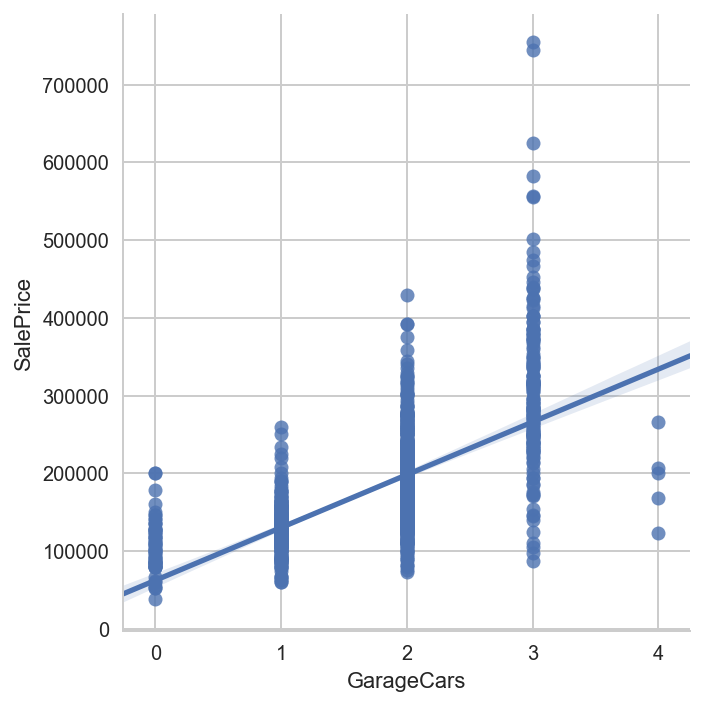

In [40]:
sns.lmplot(x ='GarageCars',y ='SalePrice', data = df_train)

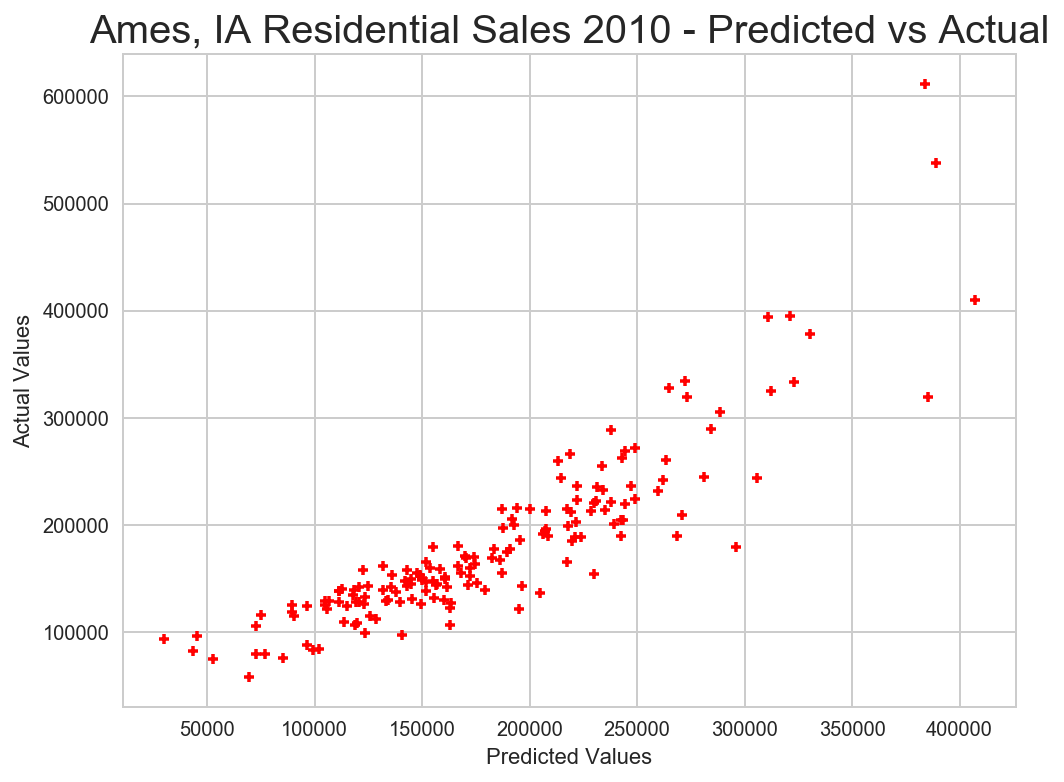

In [41]:
plt.figure(figsize=(8,6))
plt.scatter(predictions, y2, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Ames, IA Residential Sales 2010 - Predicted vs Actual", fontsize=20)
plt.show()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [42]:
#Load sales price as the target for our model
target = df_train['SalePrice']

In [43]:
df_change_train.describe()

,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.00000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.000000,1236.0000,1236.000000
mean,6.166667,5.597896,1985.353560,107.431230,453.020227,45.50890,585.551780,6.130259,95.635113,48.293689,21.152104,3.572816,15.798544,3.2589,38.576052
std,1.350863,1.098086,20.383579,186.580638,458.786211,157.68648,442.567028,49.570773,124.674957,67.143127,60.877081,30.454512,57.500888,43.6505,518.441993
min,1.000000,1.000000,1950.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
25%,5.000000,5.000000,1968.000000,0.000000,0.000000,0.00000,248.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
50%,6.000000,5.000000,1994.000000,0.000000,398.500000,0.00000,495.000000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.0000,0.000000
75%,7.000000,6.000000,2004.000000,170.000000,721.000000,0.00000,825.000000,0.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.0000,0.000000
max,10.000000,9.000000,2009.000000,1600.000000,5644.000000,1474.00000,2336.000000,572.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.0000,15500.000000


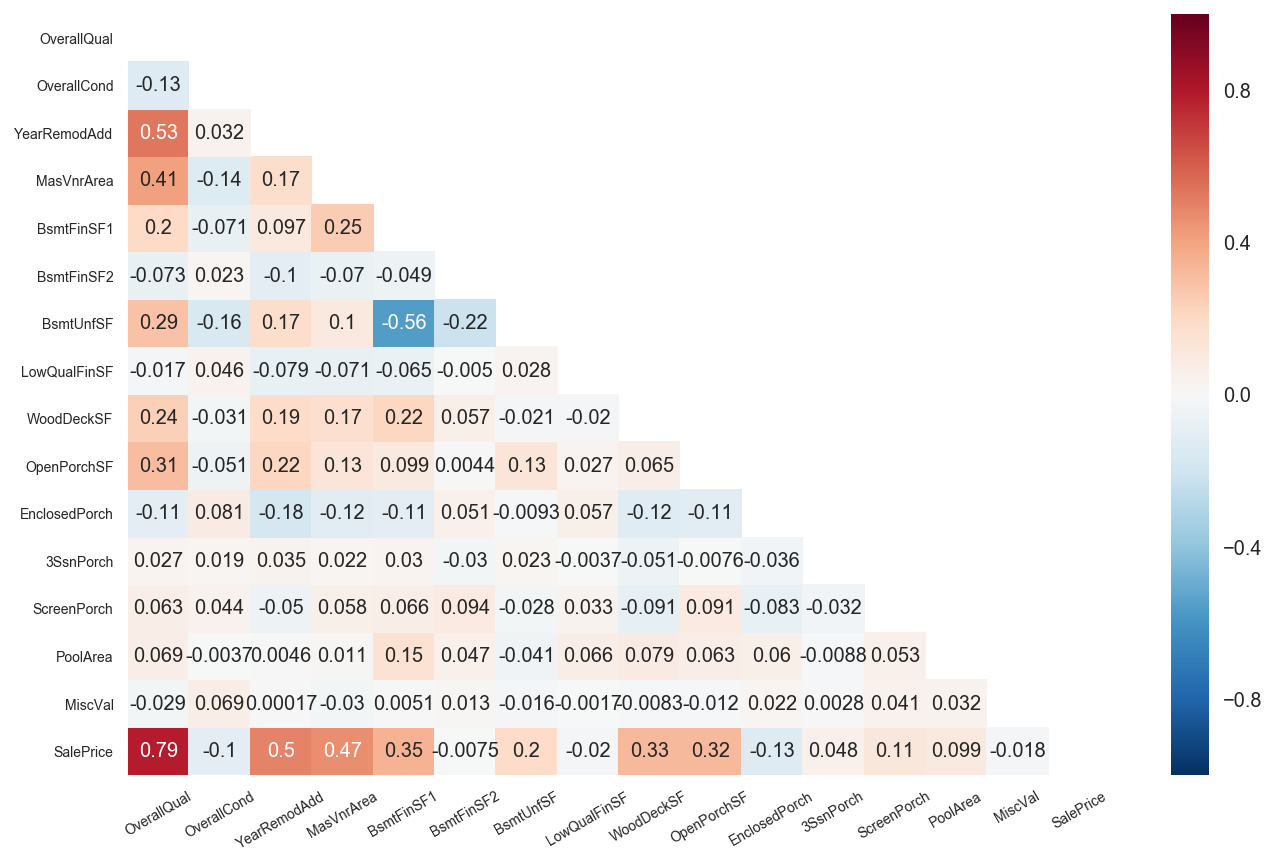

In [44]:
#Running heat map on fixed numerical values
def correlation_heat_map(df):
    corrs = df.corr()
    fig, ax = plt.subplots(figsize=(11,7))
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(corrs, mask=mask, annot=True)
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=7, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=7, rotation=0)
    plt.show()

df_with_target2 = df_change_train.copy()
df_with_target2['SalePrice'] = target
correlation_heat_map(df_with_target2)

In [45]:
# Initially trying Linear Regression with Statsmodels OLS 
X3 = df_change_train[["OverallQual","YearRemodAdd","MasVnrArea","BsmtFinSF1","WoodDeckSF"]].values
X3 = np.concatenate([X3, np.ones((X3.shape[0], 1))], axis=1)
y3 = df_train["SalePrice"]
model = sm.OLS(y3, X3)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     551.5
Date:                Fri, 02 Jun 2017   Prob (F-statistic):          4.87e-311
Time:                        08:41:36   Log-Likelihood:                -14963.
No. Observations:                1236   AIC:                         2.994e+04
Df Residuals:                    1230   BIC:                         2.997e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          3.587e+04   1194.906     30.015      0.000      3.35e+04  3.82e+04
x2           425.9728     72.872      5.845      0.000       283.006   568.940
x3            58.9464      7.509      7.850      0.000        44.214    73.679
x4            27.3765      2.870      9.539      0.000        21.746    33.007
x5            64.6745     10.534      6.140      0.000        44.008    85.340
const      -9.083e+05   1.41e+05     -6.437      0.000     -1.19e+06 -6.31e+05
==============================================================================
Omnibus:                      432.289   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9829.303
Skew:                           1.071   Prob(JB):                         0.00
Kurtosis:                      16.648   Cond. No.                     2.31e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
# Results: R^2 for the test was .692 on training data, again not bad. P-values for all 5 variables were again below
# 0.001, so results seem reasonable. Will now try with test data.

In [47]:
# Now running with test data: 
X4 = df_change_test[["OverallQual","YearRemodAdd","MasVnrArea","BsmtFinSF1","WoodDeckSF"]].values
X4 = np.concatenate([X4, np.ones((X4.shape[0], 1))], axis=1)
y4 = df_test["SalePrice"]
model = sm.OLS(y4, X4)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     92.00
Date:                Fri, 02 Jun 2017   Prob (F-statistic):           3.08e-45
Time:                        08:41:36   Log-Likelihood:                -1996.3
No. Observations:                 166   AIC:                             4005.
Df Residuals:                     160   BIC:                             4023.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          3.466e+04   3146.490     11.015      0.000      2.84e+04  4.09e+04
x2           285.2546    190.865      1.495      0.137       -91.686   662.195
x3           107.3791     23.754      4.521      0.000        60.468   154.290
x4            49.3939      7.969      6.198      0.000        33.655    65.133
x5            59.3788     23.565      2.520      0.013        12.841   105.916
const      -6.351e+05   3.69e+05     -1.720      0.087     -1.36e+06  9.43e+04
==============================================================================
Omnibus:                       35.421   Durbin-Watson:                   1.829
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.882
Skew:                           0.940   Prob(JB):                     2.02e-17
Kurtosis:                       5.753   Cond. No.                     2.37e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
predictions  =  model.predict()

In [49]:
# TEST on second model: R^2 increased to .742. Two variables, "YearRemodAdd" and "WoodDeckSF" showed a positive 
# P-value.

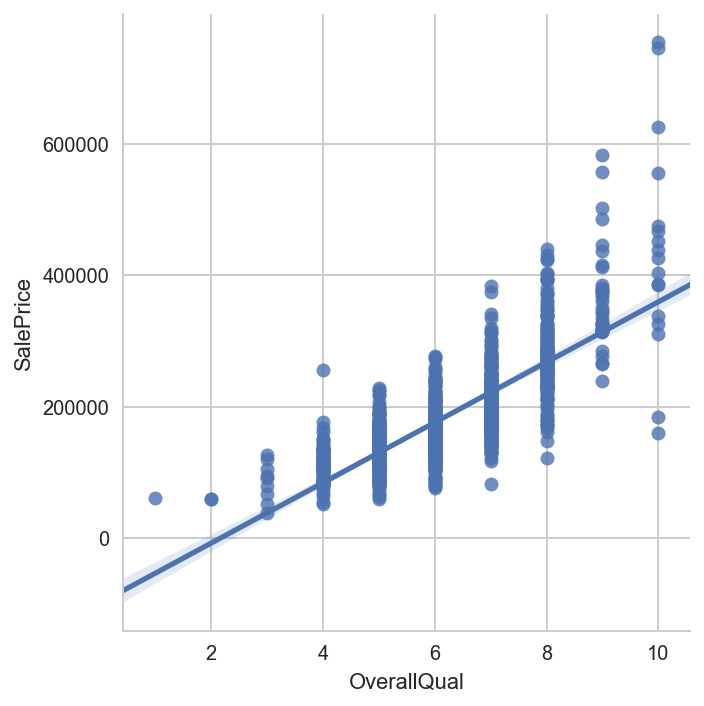

In [50]:
sns.lmplot(x ='OverallQual',y ='SalePrice', data = df_train) #$34,600 approximate increase for each grade higher

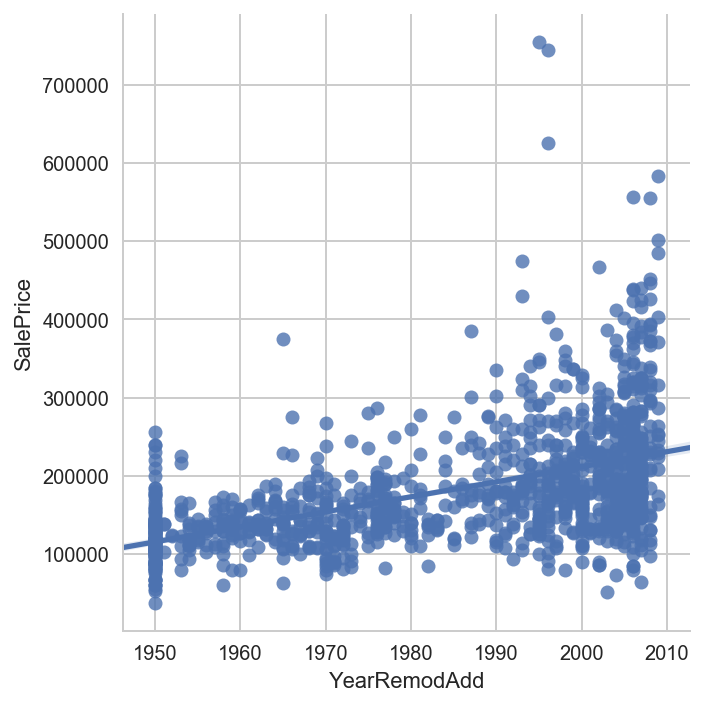

In [51]:
sns.lmplot(x ='YearRemodAdd',y ='SalePrice', data = df_train) # $285 / yr

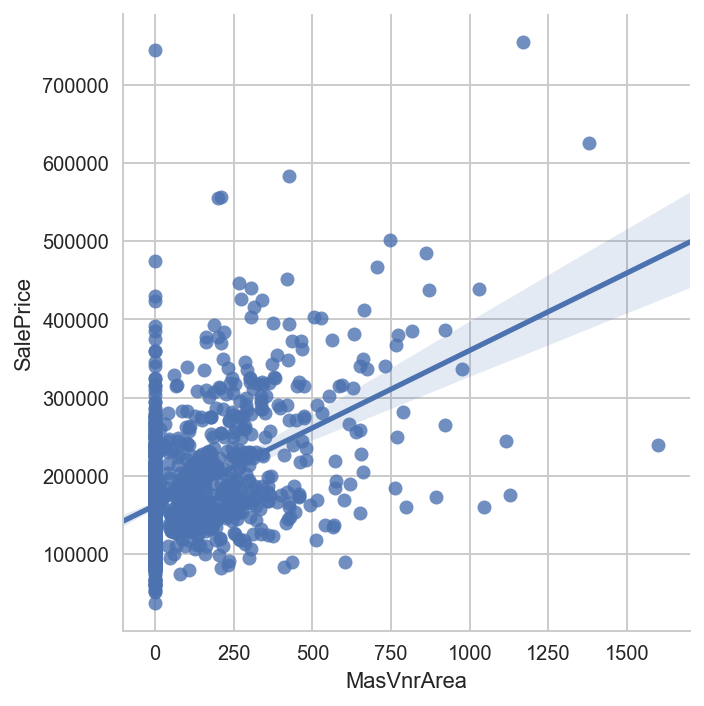

In [52]:
sns.lmplot(x ='MasVnrArea',y ='SalePrice', data = df_train) # $10,700 per 100 sq feet

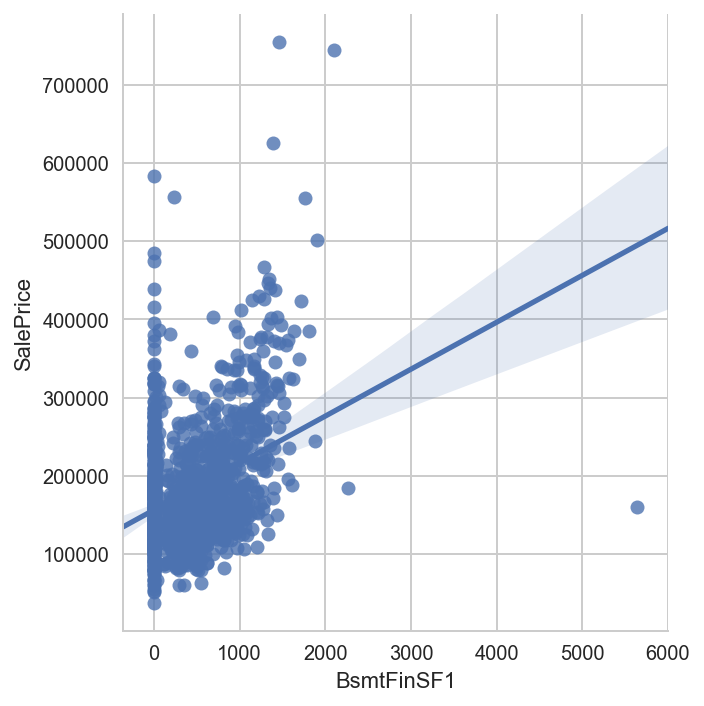

In [53]:
sns.lmplot(x ='BsmtFinSF1',y ='SalePrice', data = df_train) # $4,900 per 100 sq feet

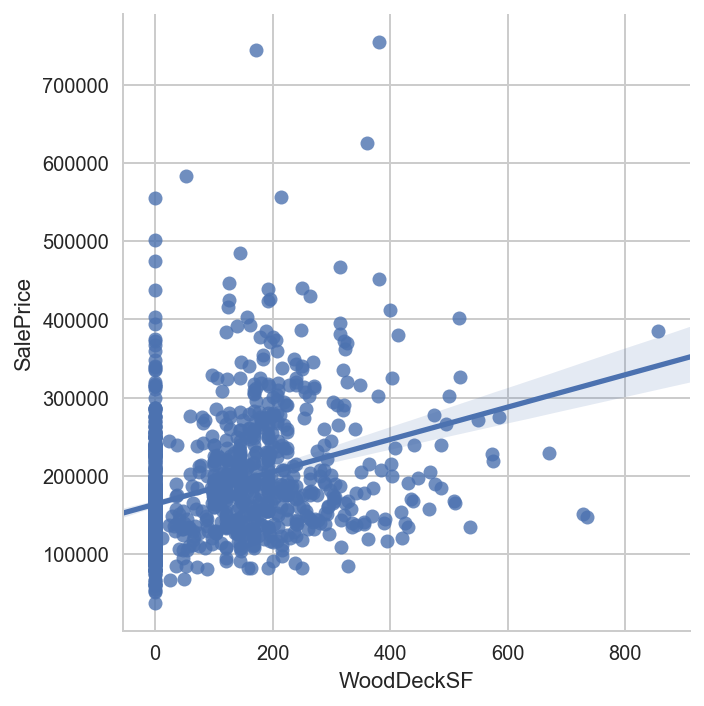

In [54]:
sns.lmplot(x ='WoodDeckSF',y ='SalePrice', data = df_train) # $5,900 per 100 sq feet

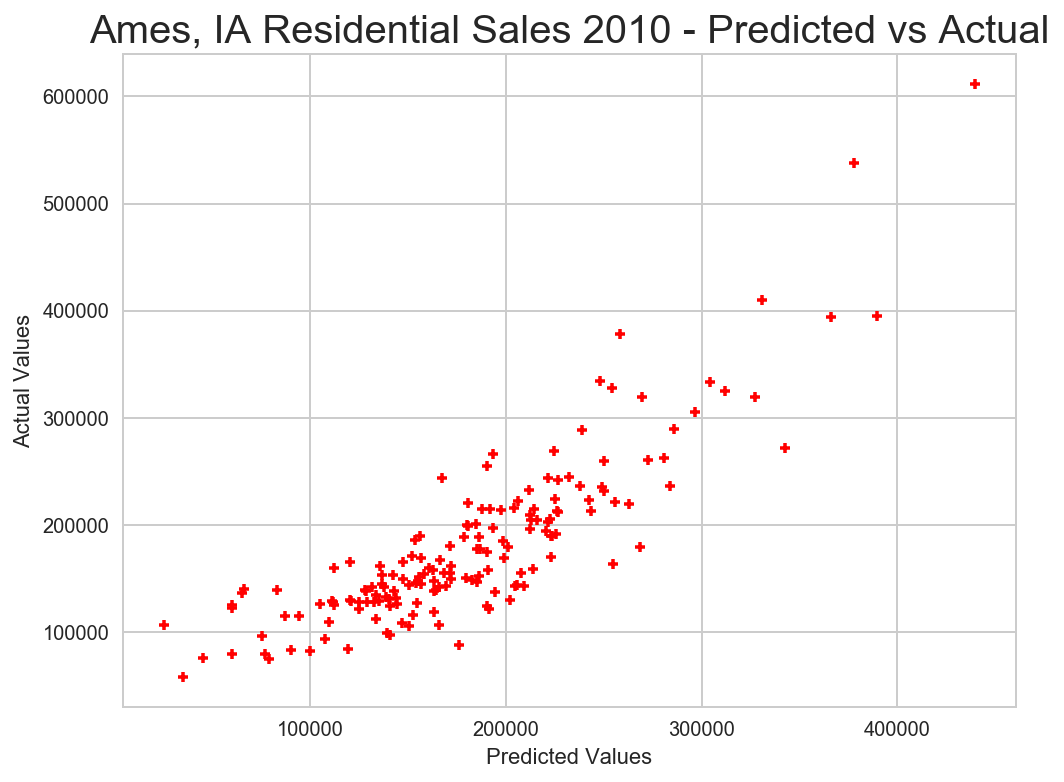

In [56]:
plt.figure(figsize=(8,6))
plt.scatter(predictions, y4, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.title("Ames, IA Residential Sales 2010 - Predicted vs Actual", fontsize=20)
plt.show()

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [27]:
# A: